In [14]:
from qiskit.transpiler import CouplingMap
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit import QuantumCircuit, Parameter
import json
import networkx as nx

import sys
sys.path.append("../src/")
from tap_mapper.tap_pass_grb import TAPMapping

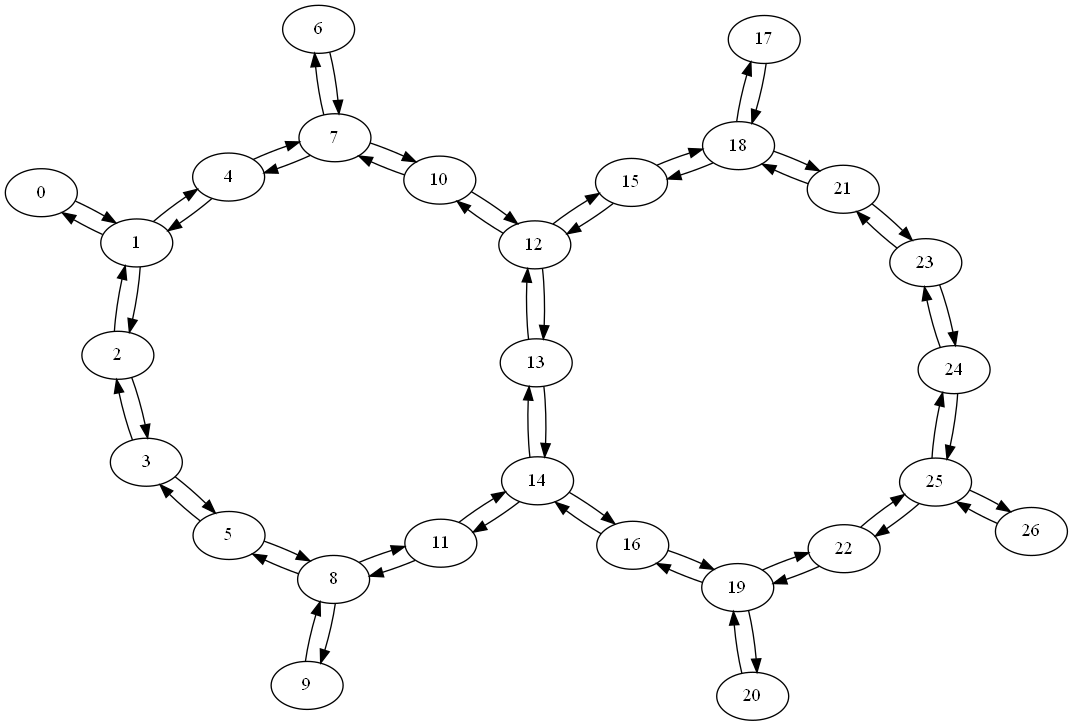

In [15]:
with open("../data/coupling_ehningen.json","r") as f:
    coupling_graph = json.load(f)
cm = CouplingMap(coupling_graph)
cm.make_symmetric()
cm.draw()

In [16]:
with open("../data/qaoa_schedules.txt","r") as f:
    qaoa_schedules = eval(f.read())

In [17]:
instance = "reg"
if instance == "complete":
    nvars = 5
    g = nx.complete_graph(nvars)
    sched = qaoa_schedules["complete"]
if instance == "reg":
    nvars = 10
    deg = 3
    g = nx.random_regular_graph(deg,nvars,seed=333)
    sched = qaoa_schedules["reg"]
if instance == "line":
    nvars = 14
    g = nx.path_graph(nvars)
    sched = qaoa_schedules["line"]

maxdepth = 7

In [18]:
# build circuit
def qaoa_circuit(graph,gamma,beta):
    V = list(graph.nodes)
    qc = QuantumCircuit(max(V)+1, max(V)+1)
    qc.h(V)
    qc.barrier()
    for p in range(0,len(gamma)):
        usednodes = []
        E = list(graph.edges)
        while E:
            canditatedges = [e for e in E if e[0] not in usednodes and e[1] not in usednodes]
            if canditatedges:
                edge = canditatedges[0]
            else:
                edge = E[0]
                usednodes = []
            E.remove(edge)
            k = edge[0]
            l = edge[1]
            w = 1
            usednodes += [k,l]
            qc.cx(k, l)
            qc.rz(-1*w*gamma[p], l)
            qc.cx(k, l)
        qc.barrier()
        qc.rx(2*beta[p], V)
    qc.barrier()
    qc.measure(V,V)
    return qc


In [19]:
qc = []
for depth in range(1,maxdepth+1):
      qc.append( qaoa_circuit(g,sched[depth-1][:depth],sched[depth-1][depth:]))

In [20]:
qc[0].draw()

┌───┐ ░                                                           »
 q_0: ┤ H ├─░───■─────────────────────────────────────■──────────────■──»
      ├───┤ ░   │                                     │              │  »
 q_1: ┤ H ├─░───┼────■──────────────────────■─────────┼──────────────┼──»
      ├───┤ ░   │  ┌─┴─┐┌────────────┐    ┌─┴─┐       │              │  »
 q_2: ┤ H ├─░───┼──┤ X ├┤ Rz(-0.693) ├────┤ X ├───────┼──────────────┼──»
      ├───┤ ░   │  └───┘└────────────┘    └───┘       │              │  »
 q_3: ┤ H ├─░───┼────■────────────────────────────────┼────■─────────┼──»
      ├───┤ ░   │    │                                │    │         │  »
 q_4: ┤ H ├─░───┼────┼────────■───────────────────────┼────┼────■────┼──»
      ├───┤ ░   │    │      ┌─┴─┐     ┌────────────┐  │    │  ┌─┴─┐  │  »
 q_5: ┤ H ├─░───┼────┼──────┤ X ├─────┤ Rz(-0.693) ├──┼────┼──┤ X ├──┼──»
      ├───┤ ░   │    │      └───┘     └────────────┘  │    │  └───┘  │  »
 q_6: ┤ H ├─░───┼────┼────────■───────────────────────┼────┼────■────┼──»
      ├───┤ ░ ┌─┴─┐  │        │       ┌────────────┐┌─┴─┐  │    │    │  »
 q_7: ┤ H ├─░─┤ X ├──┼────────┼───────┤ Rz(-0.693) ├┤ X ├──┼────┼────┼──»
      ├───┤ ░ └───┘┌─┴─┐      │       ├────────────┤└───┘┌─┴─┐  │    │  »
 q_8: ┤ H ├─░──────┤ X ├──────┼───────┤ Rz(-0.693) ├─────┤ X ├──┼────┼──»
      ├───┤ ░      └───┘    ┌─┴─┐     ├────────────┤     └───┘┌─┴─┐┌─┴─┐»
 q_9: ┤ H ├─░───────────────┤ X ├─────┤ Rz(-0.693) ├──────────┤ X ├┤ X ├»
      └───┘ ░               └───┘     └────────────┘          └───┘└───┘»
c: 10/══════════════════════════════════════════════════════════════════»
                                                                        »
«                                                                              »
« q_0: ───────────────────────────────────■──────────────■─────────────────────»
«                                         │              │  ┌───┐┌────────────┐»
« q_1: ───────────────────────────────────┼──────────────┼──┤ X ├┤ Rz(-0.693) ├»
«                                         │              │  └─┬─┘└────────────┘»
« q_2: ────────────────■──────────────────┼─────────■────┼────┼────────────────»
«          ┌───┐       │  ┌────────────┐  │  ┌───┐  │    │    │                »
« q_3: ────┤ X ├───────┼──┤ Rz(-0.693) ├──┼──┤ X ├──┼────┼────┼────────■───────»
«          └─┬─┘       │  └────────────┘  │  └─┬─┘  │    │    │      ┌─┴─┐     »
« q_4: ──────┼─────────┼──────────────────┼────┼────┼────┼────┼──────┤ X ├─────»
«            │       ┌─┴─┐┌────────────┐  │    │  ┌─┴─┐┌─┴─┐  │  ┌───┴───┴────┐»
« q_5: ──────┼───────┤ X ├┤ Rz(-0.693) ├──┼────┼──┤ X ├┤ X ├──┼──┤ Rz(-0.693) ├»
«            │       ├───┤├────────────┤  │    │  ├───┤└───┘  │  └────────────┘»
« q_6: ──────┼───────┤ X ├┤ Rz(-0.693) ├──┼────┼──┤ X ├───────┼────────────────»
«            │       └─┬─┘└────────────┘  │    │  └─┬─┘       │                »
« q_7: ──────■─────────┼──────────────────┼────■────┼─────────■────────────────»
«                      │                  │         │                          »
« q_8: ────────────────■──────────────────┼─────────■──────────────────────────»
«      ┌────────────┐                   ┌─┴─┐                                  »
« q_9: ┤ Rz(-0.693) ├───────────────────┤ X ├──────────────────────────────────»
«      └────────────┘                   └───┘                                  »
«c: 10/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                          »
« q_0: ─────────────────────■──────────────────────────────────────────────»
«                           │  ┌───┐                                       »
« q_1: ─────────────────────┼──┤ X ├─────────────────■─────────────────────»
«                           │  └─┬─┘                 │                     »
« q_2: ──■──────────────────┼────┼─────────■─────────┼──

In [21]:
with open("../data/error_data_ehningen.txt","r") as f:
    error_data_ehningen = eval(f.read())

In [22]:
# For qaoa circuits, it is sufficient to map a single qaoa layer.
# The entire qaoa circuit is then mapped by simply composing the mapped single layer circuit, alternatingly reversing it.
def route_qaoa_layer(subg,lam = 0.5):
    b = Parameter(r'\beta')
    g = Parameter(r'\gamma')
    qcl = qaoa_circuit(subg,[g],[b])

    dag = circuit_to_dag(qcl) 
    TAPPassCT = TAPMapping(cm,
                           cxerrors=error_data_ehningen["crosstalk"],
                           qerrors=error_data_ehningen["sq_errors"],
                           crosstalk=error_data_ehningen["crosstalk"])

    dagctapct = TAPPassCT.run(dag)

    qcr = dag_to_circuit(dagctapct) 
    return qcr, TAPPassCT.placement


def build_qaoa(subg,sched,qcr,LayerPlacement):
    depth = len(sched)//2
    nvars = subg.number_of_nodes()

    
    qcrl = qcr.copy()
    qcrl.data = qcrl.data[nvars:-2*nvars-1]
    qcrx = qcr.copy()
    qcrx.data = qcrx.data[-2*nvars-1:-nvars]
    qc_tap = qcr.copy()
    qc_tap.data = qc_tap.data[:nvars]
    placement = LayerPlacement[0]
    for lay in range(1,depth+1):

        qc_tap = qc_tap.compose(qcrl,)
        qc_tap = qc_tap.compose(qcrx,)

        '''Parameters are alphabetically sorted'''
        qc_tap = qc_tap.assign_parameters([sched[depth+lay-1],sched[lay-1]])
        qcrl.data = qcrl.data[::-1]
    qcf = qcr.copy()
    qcf.data = qcf.data[-nvars:]
    if depth%2 == 0:
        qc_tap = qc_tap.compose(qcf,qubits=[placement[LayerPlacement[-1].index(q)] for q in range(27)])
    else:
        qc_tap = qc_tap.compose(qcf,)
    return qc_tap

In [23]:
qc_tap = []
n_swaps_tap = []
depth_tap = []
qcr_layer, p = route_qaoa_layer(g)

for depth in range(1,maxdepth+1):
    
        qc_tap.append( build_qaoa(g, sched[depth-1], qcr_layer, p) )
        n_swaps_tap.append(qc_tap[-1].count_ops().get('swap',0))
        depth_tap.append( qc_tap[-1].depth() )

In [24]:
print(n_swaps_tap)

[22, 44, 66, 88, 110, 132, 154]


In [25]:
qc_tap[0].draw()

»
 q_0: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
 q_1: ─────────────────────────────────────────────────────────────────────────»
      ┌───┐ ░ ┌───┐┌────────────┐    ┌───┐                                     »
 q_2: ┤ H ├─░─┤ X ├┤ Rz(-0.693) ├────┤ X ├─────────────────────────────X───────»
      ├───┤ ░ └─┬─┘└────────────┘    └─┬─┘                             │       »
 q_3: ┤ H ├─░───■──────────────────────■─────────X────────────X────────X───────»
      └───┘ ░                                    │            │                »
 q_4: ───────────────────────────────────────────┼────────────┼────────────────»
                                                 │            │                »
 q_5: ───────────────────────────────────────────X───────X────X────────────────»
      ┌───┐ ░ ┌───┐┌────────────┐    ┌───┐               │                     »
 q_6: ┤ H ├─░─┤ X ├┤ Rz(-0.693) ├────┤ X ├───────────────┼────■────────────────»
      ├───┤ ░ └─┬─┘└────────────┘    └─┬─┘               │  ┌─┴─┐┌────────────┐»
 q_7: ┤ H ├─░───■──────────────────────■─────────────X───┼──┤ X ├┤ Rz(-0.693) ├»
      ├───┤ ░          ┌───┐     ┌────────────┐┌───┐ │   │  └───┘└────────────┘»
 q_8: ┤ H ├─░──────────┤ X ├─────┤ Rz(-0.693) ├┤ X ├─┼───X─────────────────────»
      └───┘ ░          └─┬─┘     └────────────┘└─┬─┘ │                         »
 q_9: ───────────────────┼───────────────────────┼───┼─────────────────────────»
      ┌───┐ ░            │                       │   │                         »
q_10: ┤ H ├─░───■────────┼─────────────■─────────┼───X───X────■────────────────»
      ├───┤ ░   │        │             │         │       │    │                »
q_11: ┤ H ├─░───┼────────■─────────────┼─────────■───────┼────┼────────────────»
      ├───┤ ░ ┌─┴─┐┌────────────┐    ┌─┴─┐               │  ┌─┴─┐┌────────────┐»
q_12: ┤ H ├─░─┤ X ├┤ Rz(-0.693) ├────┤ X ├───────X───────X──┤ X ├┤ Rz(-0.693) ├»
      ├───┤ ░ ├───┤├────────────┤    ├───┤       │          └───┘└────────────┘»
q_13: ┤ H ├─░─┤ X ├┤ Rz(-0.693) ├────┤ X ├───────X───X───■─────────────────────»
      ├───┤ ░ └─┬─┘└────────────┘    └─┬─┘           │ ┌─┴─┐                   »
q_14: ┤ H ├─░───■──────────────────────■─────────────X─┤ X ├───────────────────»
      └───┘ ░                                          └───┘                   »
q_15: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_16: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_17: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_18: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_19: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_20: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_21: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_22: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_23: ─────────────────────────────────────────────────────────────────────────»
                                                                               »
q_24: ─────────────────────────────────────────────────────────────────────────»
                             